In [1]:
import sys
import keras
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division, print_function
from tqdm import tqdm

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [26]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
def get_binary_data(x, y, classes):
  x_r = []
  y_r = []

  for idx, value in enumerate(y):
    if value == classes[0]:
      x_r.append(x[idx])
      y_r.append(0)
    elif value == classes[1]:
      x_r.append(x[idx])
      y_r.append(1)
      
  return np.array(x_r), np.array(y_r)

In [5]:
x_train_r, y_train_r = get_binary_data(x_train, y_train, (1, 2))
x_test_r, y_test_r = get_binary_data(x_test, y_test, (1, 2))

In [6]:
y_train_r

array([0, 1, 0, ..., 1, 1, 0])

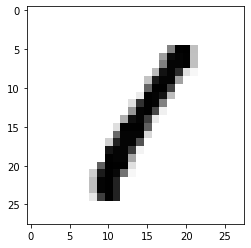

In [7]:
plt.imshow(x_train_r[0], cmap='gray_r')

In [8]:
x_train_flatten = x_train_r.reshape(x_train_r.shape[0], -1)
x_test_flatten = x_test_r.reshape(x_test_r.shape[0], -1)

print('X_train_flatten shape: ' + str(x_train_flatten.shape))
print('Y_train shape: ' + str(y_train_r.shape))
print('X_test_flatten shape: ' + str(x_test_flatten.shape))
print('Y_test shape: ' + str(y_test_r.shape))

x_train_std = x_train_flatten / 255.
x_test_std = x_test_flatten / 255.

X_train_flatten shape: (12700, 784)
Y_train shape: (12700,)
X_test_flatten shape: (2167, 784)
Y_test shape: (2167,)


**Sigmoid:** $f(z) = \dfrac{1}{1+e^{-z}}$ where $z=w^T x$

In [9]:
def sigmoid(z):
    sig = 1.0 / (1.0 + np.exp(-z))
    return sig

In [24]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(5.5) = " + str(sigmoid(4.5)))
print ("sigmoid(-7) = " + str(sigmoid(-6)))

sigmoid(0) = 0.5
sigmoid(5.5) = 0.9890130573694068
sigmoid(-7) = 0.0024726231566347743


__predict__: 모델의 예측값 $x_i$; $h(w^Tx_i)=\dfrac{1}{1+e^{-w^T x_i}}$ 

__loss__: 모델의 예측값과 실제값의 차이 $J(w)=\frac{1}{n}\sum_{i=1}^n[-y_i\text{log}\{h(w^Tx_i)\} - (1-y_i)\text{log}\{1-h(w^Tx_i)\}]$

In [11]:
def forward(x, y, w, eps=1e-8):
    predict = sigmoid(np.dot(x, w))
    loss = np.sum(-y * np.log(predict + eps) - (1 - y) * np.log(1-predict + eps))
    loss /= len(y)
    
    return predict, loss

$$
\begin{aligned}
\frac{\partial J(\boldsymbol{w})}{\partial \boldsymbol{w}} &=-\frac{1}{n} \sum_{i=1}^{n}\left[y_{i}\left(1-h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)\right)-\left(1-y_{i}\right) h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)\right] \boldsymbol{x}_{i} \\
&=\frac{1}{n} \sum_{i=1}^{n}\left[h\left(\boldsymbol{w}^{T} \boldsymbol{x}_{i}\right)-y_{i}\right] \boldsymbol{x}_{i}\\
&= \frac{1}{n} (\hat{Y}-Y)X
\end{aligned}
$$

__grad_w__: Gradient of weights, 가중치로 손실함수를 편미분한 값

In [12]:
def backward(x, y, predict):
    grad_w = np.dot((predict - y), x) / len(y)
    return grad_w

In [13]:
def bias_unit(x, w, b):
    one_pad = np.ones(x.shape[0]).reshape(-1, 1)
    x_bar = np.hstack((x, one_pad))
    w_bar = np.append(w, b)
    return x_bar, w_bar

In [14]:
def initialize_params(x_train, verbose=False):
    
    w = np.random.normal(size=x_train.shape[1])
    b = 0
    
    x_train_bar, w_bar = bias_unit(x_train, w, b)
    if verbose:
        print('Before adding the bias unit')
        print('shape of x_train:, ', x_train.shape)
        print('w: ', w.__repr__())
        print('b: ', b.__repr__(), end='\n\n')
        print('After adding the bias unit')
        print('shape of x_train_bar:, ', x_train_bar.shape)
        print('w_bar: ', w_bar.__repr__())
    
    return x_train_bar, w_bar

__acc__: $\dfrac{1}{n}\sum_{i=1}^{n}\mathbf{1}_{[\hat{y}_i=y_i]} \times 100 (\%)$ where $\hat{y}_i = \mathbf{1}_{[h(w^Tx_i)\geq0.5]}$. And $\mathbf{1}_{A}$ is defined as:

$$\mathbf{1}_{A}:=\left\{\begin{array}{ll}
1 & \text { if } A \text{ is true}\\
0 & \text { if } A \text{ is false}
\end{array}\right.$$

예측값이 0.5 이상이면 1로 간주

In [15]:
def accuracy(predict, y):
    predict_binary = np.array([1 if x >= 0.5 else 0 for x in predict])
    acc = np.sum((predict_binary == y)) / len(y) * 100
    return acc

In [20]:
# hyperparameter
num_of_iteration = 500
learning_rate = 0.25

# fix random seed for reproducibility
np.random.seed(100)

# 모델 초기화 및 bias 추가
x_train_bar, w_bar = initialize_params(x_train_std, False)
    
it = tqdm(range(num_of_iteration))
for i in it:
    
    # 예측값 및 오차 계산
    predict, loss = forward(x_train_bar, y_train_r, w_bar)                                                       

    # 정확도 측정
    train_acc = accuracy(predict, y_train_r)                                                 

    # 그래디언트 계산
    grad_w = backward(x_train_bar, y_train_r, predict)                                                      

    # 가중치 업데이트
    w_bar -= learning_rate * grad_w
    
    if i % 100 == 0:
        it.set_postfix(accuracy='{:.2f}'.format(train_acc),
                      loss='{:.4f}'.format(loss))
    
# 훈련 정확도 계산
predict, _ = forward(x_train_bar, y_train_r, w_bar)
train_acc = accuracy(predict, y_train_r)
print('train accuracy: {:.2f}'.format(train_acc))

# 테스트 데이터에 bias 추가
unit_ones = np.ones((len(x_test_std), 1))
x_test_bar = np.concatenate((x_test_std, unit_ones), axis=1)

# 테스트 데이터 정확도 계산
predict, _ = forward(x_test_bar, y_test_r, w_bar)
test_acc = accuracy(predict, y_test_r)
print('test accuracy: {:.2f}'.format(test_acc))

100%|██████████| 500/500 [00:11<00:00, 42.52it/s, accuracy=98.02, loss=0.0766]

train accuracy: 98.15
test accuracy: 98.25


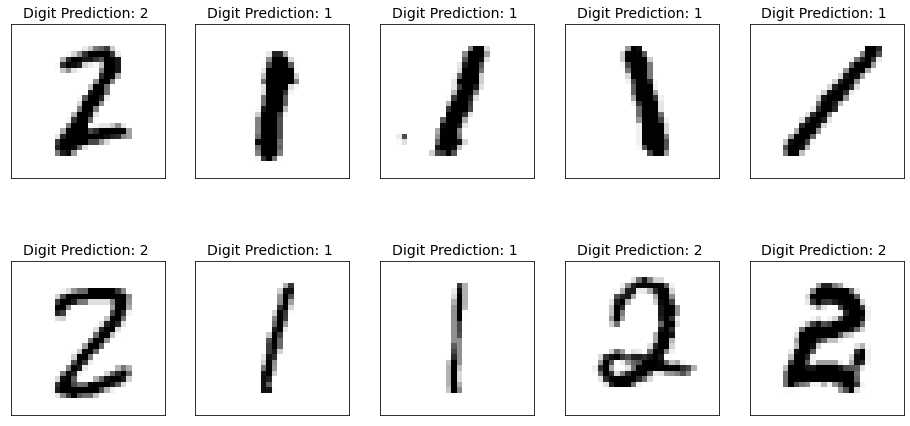

In [22]:
np.random.seed(77)
idxs = np.random.choice(len(y_test_r), 10, replace=False)
label_to_class = {0: '1', 1: '2'}

plt.figure(figsize=(16, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    predict, _ = forward(x_test_bar, y_test_r, w_bar)
    pred_label = (predict[idx] >= 0.5).astype(np.int)
    plt.imshow(x_test_r[idx], cmap='gray_r')
    plt.title('Digit Prediction: {} '.format(label_to_class[pred_label]), fontsize=14)
    plt.xticks([]); plt.yticks([])